# Dynamically Returning Directly

In this example we will build a chat executor where the LLM can optionally decide to return the result of a tool call as the final answer. This is useful in cases where you have tools that can sometimes generate responses that are acceptable as final answers, and you want to use the LLM to determine when that is the case

This examples builds off the base chat executor. It is highly recommended you learn about that executor before going through this notebook. You can find documentation for that example [here](./base.ipynb).

Any modifications of that example are called below with **MODIFICATION**, so if you are looking for the differences you can just search for that.


<div class="admonition tip">
    <p class="admonition-title">Note</p>
    <p>
        In this how-to, we will create our agent from scratch to be transparent (but verbose). You can accomplish similar functionality using the <code>create_react_agent(model, tools=tool, interrupt_before=["agent" | "tools"], interrupt_after=["agent" | "tools"], checkpointer=checkpointer)</code> (<a href="https://langchain-ai.github.io/langgraph/reference/prebuilt/#create_react_agent">API doc</a>) constructor. This may be more appropriate if you are used to LangChain’s <a href="https://python.langchain.com/v0.2/docs/how_to/agent_executor/#concepts">AgentExecutor</a> class.
    </p>
</div>    

## Setup

First we need to install the packages required

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain langchain_openai tavily-python

Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [2]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use a built-in search tool via Tavily.
However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/v0.2/docs/how_to/custom_tools) on how to do that.

**MODIFICATION**

We overwrite the default schema of the input tool to have an additional parameter for returning directly.

In [4]:
from langchain_core.pydantic_v1 import BaseModel, Field


class SearchTool(BaseModel):
    """Look up things online, optionally returning directly"""

    query: str = Field(description="query to look up online")
    return_direct: bool = Field(
        description="Whether or the result of this should be returned directly to the user without you seeing what it is",
        default=False,
    )

In [5]:
!pip install -q langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.6 MB/s eta 0:00:00


In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool = TavilySearchResults(max_results=1, args_schema=SearchTool)
tools = [search_tool]

We can now wrap these tools in a simple ToolExecutor.
This is a real simple class that takes in a ToolInvocation and calls that tool, returning the output.
A ToolInvocation is any class with `tool` and `tool_input` attribute.


In [7]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

## Set up the model

Now we need to load the chat model we want to use.
Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.


In [10]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this by converting the LangChain tools into the format for OpenAI function calling, and then bind them to the model class.


In [11]:
model = model.bind_tools(tools)

## Define the agent state

The main type of graph in `langgraph` is the [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph).
This graph is parameterized by a state object that it passes around to each node.
Each node then returns operations to update that state.
These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute.
Whether to set or add is denoted by annotating the state object you construct the graph with.

For this example, the state we will track will just be a list of messages.
We want each node to just add messages to that list.
Therefore, we will use a `TypedDict` with one key (`messages`) and annotate it so that the `messages` attribute is always added to.


In [12]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.


In [13]:
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation

**MODIFICATION**

We change the `should_continue` function to check whether return_direct was set to True

In [14]:
# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we check if it's suppose to return direct
    else:
        arguments = last_message.tool_calls[0]["args"]
        if arguments.get("return_direct", False):
            return "final"
        else:
            return "continue"

In [15]:
# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

**MODIFICATION**

We change the tool calling to get rid of the `return_direct` parameter (not used in the actual tool call)

In [16]:
# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_call = last_message.tool_calls[0]
    tool_name = tool_call["name"]
    arguments = tool_call["args"]
    if tool_name == "tavily_search_results_json":
        if "return_direct" in arguments:
            del arguments["return_direct"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=arguments,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a ToolMessage
    tool_message = ToolMessage(
        content=str(response), name=action.tool, tool_call_id=tool_call["id"]
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [tool_message]}

## Define the graph

We can now put it all together and define the graph!

**MODIFICATION**

We add a separate node for any tool call where `return_direct=True`. The reason this is needed is that after this node we want to end, while after other tool calls we want to go back to the LLM.

In [17]:
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)
workflow.add_node("final", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Final call
        "final": "final",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")
workflow.add_edge("final", END)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

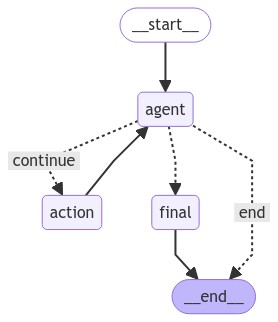

In [18]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use it!

We can now use it!
This now exposes the [same interface](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel) as all other LangChain runnables.

In [19]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in San Jerónimo de Tunán, Huancayo, Perú?")]}
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ICeLg8v1Y2CvqZwwwsQKiqNj', 'function': {'arguments': '{"query":"weather in San Jerónimo de Tunán, Huancayo, Perú"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0f03d4f0ee'}, id='run-622a1370-5198-442b-ac24-0bf2eb09f5b9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Jerónimo de Tunán, Huancayo, Perú'}, 'id': 'call_ICeLg8v1Y2CvqZwwwsQKiqNj', 'type': 'tool_call'}])]}

---

Output from node 'action':
---
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Huancayo\', \'region\': \'Junin\', \'country\': \'Peru\', \'lat\': -12.07, \'lon\': -75.23, \'tz_id\': \'America/Lima\', \'localtime_epoch\': 1722332399, \'localtime\': \'20

In [20]:
from langchain_core.messages import HumanMessage

inputs = {
    "messages": [
        HumanMessage(
            content="what is the weather in San Jerónimo de Tunán, Huancayo, Perú? return this result directly by setting return_direct = True"
        )
    ]
}
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_FzIHZp5KtKamUlAHrFIfaNqi', 'function': {'arguments': '{"query":"weather in San Jerónimo de Tunán, Huancayo, Perú","return_direct":true}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0f03d4f0ee'}, id='run-455251c2-0e4d-4e3a-aee5-3a37c95a81f5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Jerónimo de Tunán, Huancayo, Perú', 'return_direct': True}, 'id': 'call_FzIHZp5KtKamUlAHrFIfaNqi', 'type': 'tool_call'}])]}

---

Output from node 'final':
---
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Huancayo\', \'region\': \'Junin\', \'country\': \'Peru\', \'lat\': -12.07, \'lon\': -75.23, \'tz_id\': \'America/Lima\', \'localti